In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.cm as cm

import scipy
import scipy.cluster.hierarchy as sch
import time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from IPython.core.display import display, HTML

###################librerias propias

import Algos_Clustering as AlClus
import Data_Manager as MgClus
import OptSharpe
import AlgoTraiding as AlTr

In [2]:
############### Carga datos

df = pd.read_csv('Datos_filtrados_4.csv',delimiter=';',index_col='Timestamp',decimal=',')
df.index = pd.to_datetime(df.index)
print(df.shape)

for W,(dateW,groupW) in enumerate(df.groupby(pd.TimeGrouper('W'))):
    print(dateW)

(16813, 175)
2016-09-18 00:00:00
2016-09-25 00:00:00
2016-10-02 00:00:00
2016-10-09 00:00:00
2016-10-16 00:00:00
2016-10-23 00:00:00
2016-10-30 00:00:00
2016-11-06 00:00:00
2016-11-13 00:00:00


In [3]:
Dic_algos={'CKMeans':{'nemo':'KMeans'},
        'CAgglomerativeClustering_1':{'nemo':'CL'},
        'CAgglomerativeClustering_2':{'nemo':'AL'},
        'CSpectralClustering':{'nemo':'Spectral'},
        'CMiniBatchKMeans':{'nemo':'MBKMeans'},
        'CBirch':{'nemo':'Birch'},
        'CAgglomerativeClustering_3':{'nemo':'WM'},
        'MVO':{'nemo':'MVO'}
        }

#

print Dic_algos

Dic_algos['SimpleOptSharp']=AlTr.AlgoTraidingClass('SimpleOptSharp')

for i in Dic_algos:
    Dic_algos[i]=AlTr.AlgoTraidingClass()


{'CSpectralClustering': {'nemo': 'Spectral'}, 'CAgglomerativeClustering_3': {'nemo': 'WM'}, 'CAgglomerativeClustering_2': {'nemo': 'AL'}, 'CAgglomerativeClustering_1': {'nemo': 'CL'}, 'CBirch': {'nemo': 'Birch'}, 'MVO': {'nemo': 'MVO'}, 'CMiniBatchKMeans': {'nemo': 'MBKMeans'}, 'CKMeans': {'nemo': 'KMeans'}}


In [4]:
def Crea_Clusters(HistoricoW):
    ##Administrador de los datos
    DataHistW=MgClus.DataManager(pd.concat(HistoricoW))

    ##Retornos Logaritmios
    DataHistW.DataToRetLog()

    ##Matrices de distancia
    DataHistW.Compute()

    ##administrador de clusters
    MgClusters=AlClus.ClusterManager()

    ##Crea los cluster apartir de los datos historicos
    MgClusters.EvaluaClusters(DataHistW)
    ClustesAllMetods=MgClusters.getClusterEvaluations()  
    del MgClusters
    del DataHistW
    return ClustesAllMetods

In [5]:
def DatosSharpe(rets,W):
    OPTSharpTem=OptSharpe.OptSharpe(rets,W)
    
    OPTSharpTem.CompMedCov()
    ret,riez,ratSharp=OPTSharpTem.Sharp()
    return ret,riez,ratSharp

In [6]:
HistoricoW=[]
W=0

DeltaTime='2H'

for dateW,groupW in df.groupby(pd.TimeGrouper('W')):
    if(W > 3): 

        print '++++++++++++++++++++++++++Semana'+str(W)
        
        ##Retorna los clusters Creados
        ClustesAllMetods=Crea_Clusters(HistoricoW)
        
        for dateD,groupD in groupW.groupby(pd.TimeGrouper('D')):

            ##Administrador de los datos
            DataHistD=MgClus.DataManager(groupD)

            ##Retornos Logaritmios
            DataHistD.DataToRetLog()

            print(' Dia:'+str(dateD))
            
            for ii,((dateH,retsH),(date2H,groupH)) in enumerate(
                    zip(DataHistD.getRets().groupby(pd.TimeGrouper(DeltaTime)),
                        DataHistD.get_df().groupby(pd.TimeGrouper(DeltaTime))) ):
                
                if(ii>=1):

                    print('   Hora:'+str(dateH))

                    ##Instancia y computa la optimizacion de sharpe
                    OPTSharpe=OptSharpe.OptSharpe(restHHist)
                    OPTSharpe.Compute()#NClusters

                    ##Multiplica W optimizado con sharpe con el valor de la divercficacion
                    WSimplClus=OPTSharpe.getW()

                    ##Rertorna el retorno , riesgo y sharpe del cluster
                    ret,riez,ratSharp=OPTSharpe.Sharp()##################

                    del OPTSharpe


                    ##Calcula retorno real del cluster
                    Caps=groupH.as_matrix()
                    #print("\x1b[31m\"Error\"\x1b[0m")
                    Miu=np.sum((np.log(Caps[-1,:])-np.log(Caps[0,:]))*WSimplClus)


                    Dic_algos['MVO'].Miu.append(Miu)
                    Dic_algos['MVO'].MiuAcumulate.append(np.sum(Dic_algos['MVO'].Miu))
                    Dic_algos['MVO'].Time.append(dateH)
                    Dic_algos['MVO'].setName('MVO')


                    ##Itera atravez de los metodos de cluster
                    for metodo in ClustesAllMetods:

                        print '------------'+ClustesAllMetods[metodo]['Name']
                        ##Retorna los grupos del cluster especifico
                        Grupos=ClustesAllMetods[metodo]['Groups']

                        ##Nclusters y valor de la divercificacion
                        NClusters=float(len(Grupos))

                        MiuList=[]
                        WAllClusters=np.array([])
                        ListNemoAllCluster=[]

                        #Itera en los grupos
                        for grupo in Grupos:

                            ##Nemotecnicos del cluster
                            ListNemoSimplCLus=Grupos[grupo]


                            ##Instancia y computa la optimizacion de sharpe
                            OPTSharpe=OptSharpe.OptSharpe(restHHist[ListNemoSimplCLus])
                            OPTSharpe.Compute()

                            ##Multiplica W optimizado con sharpe con el valor de la divercficacion
                            WSimplClus=OPTSharpe.getW()*1./NClusters

                            #print type(ListNemoSimplCLus)
                            #print type(WSimplClus)
                            #print len(ListNemoSimplCLus)
                            #print WSimplClus.shape
                            WAllClusters=np.append(WAllClusters, WSimplClus)
                            ListNemoAllCluster.extend(ListNemoSimplCLus)
                            #print WSimplClus

                            ##Rertorna el retorno , riezgo y sharpe del cluster
                            ret,riez,ratSharp=OPTSharpe.Sharp()##################
                            del OPTSharpe


                            ##Calcula retorno real del cluster
                            Caps=groupH[ListNemoSimplCLus].as_matrix()


                            #print("\x1b[31m\"Error\"\x1b[0m")
                            #print(Caps.shape)

                            Miu=np.sum((np.log(Caps[-1,:])-np.log(Caps[0,:]))*WSimplClus)
                            MiuList.append(Miu)


                        ##Calcura retoro real del cluster completo 
                        MiuAllSimCluster=np.sum(MiuList)#*NClusters
                        Dic_algos[metodo].Miu.append(MiuAllSimCluster)
                        Dic_algos[metodo].MiuAcumulate.append(np.sum(Dic_algos[metodo].Miu))
                        Dic_algos[metodo].Time.append(dateH)
                        Dic_algos[metodo].setName(ClustesAllMetods[metodo]['Name'])
                        
                        
                        ret,riez,ratSharp=DatosSharpe(restHHist[ListNemoAllCluster],WAllClusters)
                        Dic_algos[metodo].MiuH.append(ret)
                        Dic_algos[metodo].SigmaH.append(riez)
                        Dic_algos[metodo].SharpeH.append(ratSharp)
                        #Dic_algos[metodo].Sharpe.append([ret,riez,ratSharp])
                        #print WAllClusters.shape
                        #print len(ListNemoAllCluster)
                

                restHHist=retsH
                
            del DataHistD


        HistoricoW.pop(0)
    W+=1
    HistoricoW.append(groupW)

++++++++++++++++++++++++++Semana4
 Dia:2016-10-10 00:00:00
   Hora:2016-10-10 10:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-10-10 12:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-10-10 14:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
 Dia:2016-10-11 00:00:00
   Hora:2016-10-11 10:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-10-11 12:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-10-11 14:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
 Dia

------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
 Dia:2016-11-02 00:00:00
   Hora:2016-11-02 10:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-11-02 12:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-11-02 14:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
 Dia:2016-11-03 00:00:00
   Hora:2016-11-03 10:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-11-03 12:00:00
------------Spectral
------------WM
------------AL
------------CL
------------Birch
------------MBKMeans
------------KMeans
   Hora:2016-11-03 14:00:00
------------Spectral
------------WM
--

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/spectral.py:433: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


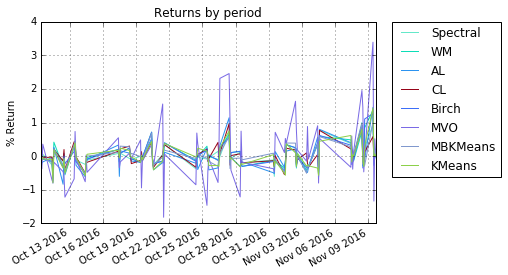

In [7]:
fig, ax = plt.subplots()

for i in Dic_algos:
    y=np.array(Dic_algos[i].Miu)*100
    #x=np.array(range(len(Dic_algos[i]['Rets_1'])))
    x=Dic_algos[i].Time
    plt.plot(x,y, label=Dic_algos[i].Name, c=np.random.rand(3,1))
    

plt.ylabel('% Return')

plt.title('Returns by period')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()


#figura_Save=1+figura_Save
#salva_figura(figura_Save)
#plt.savefig('fig_A'+str(figura_Save))

plt.show()

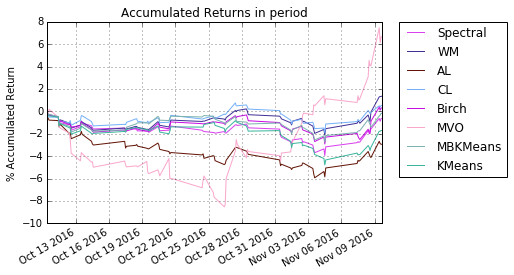

In [8]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=np.array(Dic_algos[i].MiuAcumulate)*100
    #x=np.array(range(len(Dic_algos[i]['Rets_1'])))
    x=Dic_algos[i].Time
    plt.plot(x,y, label=Dic_algos[i].Name, c=np.random.rand(3,1))
    
    
plt.ylabel('% Accumulated Return')

plt.title('Accumulated Returns in period')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()


#figura_Save=1+figura_Save
#salva_figura(figura_Save)
#plt.savefig('fig_A'+str(figura_Save))

plt.show()


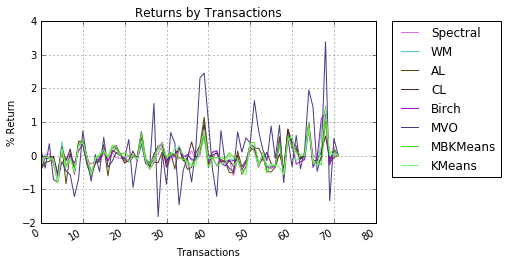

In [9]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=np.array(Dic_algos[i].Miu)*100
    x=np.array(range(len(Dic_algos[i].Miu)))
    plt.plot(x,y, label=Dic_algos[i].Name, c=np.random.rand(3,1))
    
    
plt.ylabel('% Return')
plt.title('Returns by Transactions')
plt.xlabel('Transactions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()



plt.show()


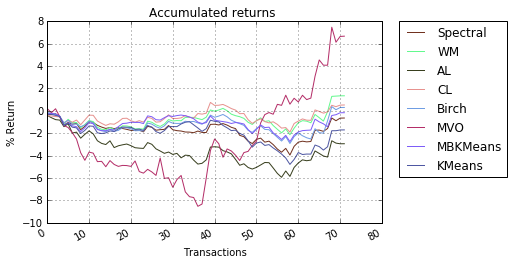

In [17]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=np.array(Dic_algos[i].MiuAcumulate)*100
    x=np.array(range(len(Dic_algos[i].MiuAcumulate)))
    plt.plot(x,y, label=Dic_algos[i].Name, c=np.random.rand(3,1))
    
    
plt.ylabel('% Return')
plt.title('Accumulated returns ')
plt.xlabel('Transactions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()



plt.show()


('CSpectralClustering', 'std', 0.31982261784257004, 'retorno medio', -0.0089246812258880516)
('CAgglomerativeClustering_3', 'std', 0.34204342992661696, 'retorno medio', 0.018662978334062812)
('CAgglomerativeClustering_2', 'std', 0.39474909705119565, 'retorno medio', -0.040801806593315754)
('CAgglomerativeClustering_1', 'std', 0.30412521446966589, 'retorno medio', 0.00725493808415556)
('CBirch', 'std', 0.34803656667857336, 'retorno medio', 0.0042082426796329125)
('SimpleOptSharp', 'std', nan, 'retorno medio', nan)
('MVO', 'std', 0.90333952558574548, 'retorno medio', 0.092577332666756912)
('CMiniBatchKMeans', 'std', 0.32058110699522091, 'retorno medio', -0.0023111667344893972)
('CKMeans', 'std', 0.34910667862785327, 'retorno medio', -0.023660231422611568)


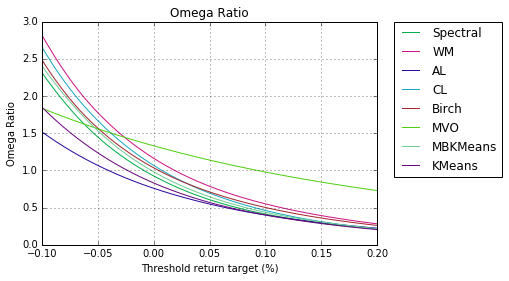

In [23]:
for i in Dic_algos:
    y=np.array(Dic_algos[i].Miu)*100
    sigma=np.std(y)
    miu=np.average(y)
    print(i,'std',sigma,'retorno medio',miu)
    omega=[]
    for L in np.arange(-0.1,1,0.001):
        r=y-L
        om=-np.sum(np.where(r>=0,r,0))/np.sum(np.where(r<0,r,0))
        omega.append(om)
    
    x=np.arange(-0.1,1,0.001)
    y=omega
    plt.plot(x,y, label=Dic_algos[i].Name, c=np.random.rand(3,1))
    
plt.title('Omega Ratio')
plt.ylabel('Omega Ratio')
plt.xlabel('Threshold return target (%)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-0.1,0.2])



plt.show()

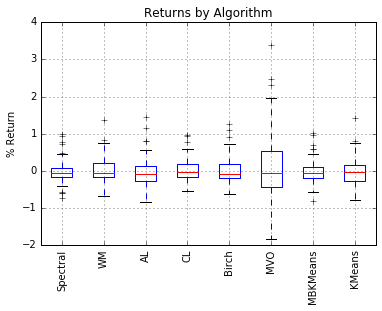

In [12]:
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111)

lista=[]
nombres=[]
for i in Dic_algos:
    if(Dic_algos[i].Name != None):
        y=np.array(Dic_algos[i].Miu)*100
        lista.append(y)
        nombres.append(Dic_algos[i].Name)


ax.boxplot(lista)
plt.xticks(range(1,len(nombres)+1), nombres, rotation =90)
plt.title('Returns by Algorithm')
plt.grid(True)
plt.ylabel('% Return')
#plt.xlabel('Algoritmos')



plt.show()


Spectral
-0.00892468122589

WM
0.0186629783341

AL
-0.0408018065933

CL
0.00725493808416

Birch
0.00420824267963

MVO
0.0925773326668

MBKMeans
-0.00231116673449

KMeans
-0.0236602314226



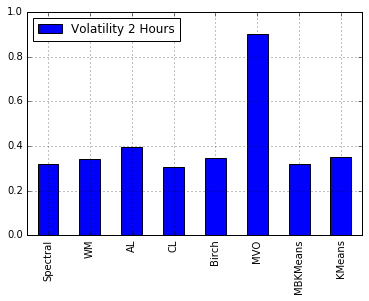

In [13]:
miuS=[]
sigmaS=[]
nameS=[]
for i in Dic_algos:
    if(Dic_algos[i].Name != None):
        y=np.array(Dic_algos[i].Miu)*100
        sigmaS.append(np.std(y))
        miuS.append(np.average(y))
        nameS.append(Dic_algos[i].Name)
        print Dic_algos[i].Name
        print np.average(y)
        print 
    

df_tem = pd.DataFrame(index=nameS)
#df_tem['Average']=np.array(miuS)
df_tem['Volatility 2 Hours']=np.array(sigmaS)
df_tem
#df_tem = df_tem.T
df_tem.plot(kind='bar')
plt.grid(True)

#plt.title('Metrics')



plt.show()

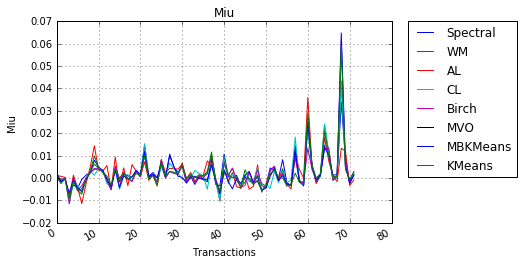

In [14]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=np.array(Dic_algos[i].MiuH)*100
    x=np.array(range(len(Dic_algos[i].MiuH)))
    plt.plot(x,y, label=Dic_algos[i].Name)
    
    
plt.ylabel('Miu')
plt.title('Miu')
plt.xlabel('Transactions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()

plt.show()


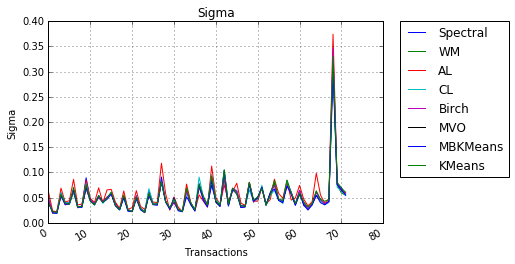

In [15]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=np.array(Dic_algos[i].SigmaH)*100
    x=np.array(range(len(Dic_algos[i].SigmaH)))
    plt.plot(x,y, label=Dic_algos[i].Name)
    
    
plt.ylabel('Sigma')
plt.title('Sigma')
plt.xlabel('Transactions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()

plt.show()


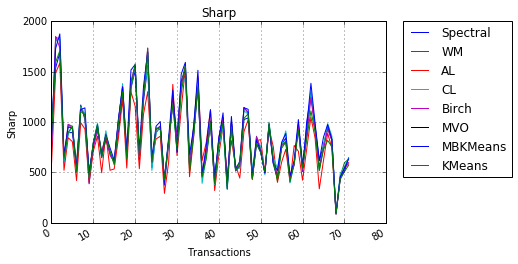

In [16]:
fig, ax = plt.subplots()
for i in Dic_algos:

    y=abs(np.array(Dic_algos[i].SharpeH))*100
    x=np.array(range(len(Dic_algos[i].SharpeH)))
    plt.plot(x,y, label=Dic_algos[i].Name)
    
    
plt.ylabel('Sharp')
plt.title('Sharp')
plt.xlabel('Transactions')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.autofmt_xdate()

plt.show()
